In [1]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.ticker import ScalarFormatter

import tensorflow as tf

import sys
sys.path.append('..') 
from utils import decode_netout, draw_boxes

import configparser

from scipy import ndimage
#import pandas as pd
#from tifffile import imsave
#from pascal_voc_writer import Writer

from tqdm import tqdm # progress bar

# Required for GPU support on Linux
config = tf.ConfigProto()
config.gpu_options.visible_device_list = "0" # Change to "1" to use 2nd GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.Session(config=config)

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import importlib
import image_generator as ig
importlib.reload(ig);

In [3]:
plt.rcParams.update({'font.size' : 16, 
                     'axes.labelpad' : 10,
                     'axes.labelsize' : 18, 
                     'axes.linewidth': 1, 
                     'xtick.major.pad': 8, 
                     'xtick.major.size': 6, 
                     'xtick.major.width': 1, 
                     'ytick.major.size': 6, 
                     'ytick.major.width': 1, 
                     'xtick.minor.size': 3, 
                     'xtick.minor.width': 1,
                     'ytick.minor.size': 3, 
                     'ytick.minor.width': 1, 
                     'xtick.top' : True, 
                     'xtick.direction' : 'in', 
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'lines.linewidth' : 1.5,})

In [6]:
def draw_boxes(image, ax, bboxes, color_list, lw=1):
    image_h, image_w = image.shape
    for bbox in bboxes:
        xmin = bbox.xmin*image_w
        ymin = bbox.ymin*image_h
        xmax = bbox.xmax*image_w
        ymax = bbox.ymax*image_h
        w, h = xmax - xmin, ymax - ymin
        class_idx = bbox.get_label()
        ax.add_patch(patches.Rectangle((xmin, ymin), w, h, ls='-', lw=lw, edgecolor=color_list[class_idx], facecolor='none'))        

In [3]:
model_name = 'model'

## Import Trained Model

### Load Protocol Buffer File (Model Weights)

In [4]:
gf = tf.gfile.FastGFile(model_name + '.pb', 'rb')
graph_def = tf.GraphDef()
graph_def.ParseFromString(gf.read()) # Parses a serialized binary message into the current message.
gf.close()

Instructions for updating:
Use tf.gfile.GFile.


### Load INI File (Parameters)

In [5]:
config = configparser.ConfigParser()
config.read(model_name + '.ini')

section = config.sections()[0] # General
IMAGE_H = int(config[section]['IMAGE_H'])
IMAGE_W = int(config[section]['IMAGE_W'])
LABELS  = config[section]['LABELS'].split(',')
CLASSES = len(LABELS)
ANCHORS = [float(a) for a in config[section]['ANCHORS'].split(',')]
INPUT_NODE_NAME  = config[section]['INPUT_NODE_NAME']
OUTPUT_NODE_NAME = config[section]['OUTPUT_NODE_NAME']

### Create Session and Import Graph

In [6]:
session.graph.as_default()
tf.import_graph_def(graph_def) # Import a serialized TensorFlow grah_def protocol buffer and place into the current default `Graph`.

In [7]:
output_tensor = session.graph.get_tensor_by_name('import/' + OUTPUT_NODE_NAME + ':0')

## Test Model on Synthetic Images

In [8]:
label_list = ['Spot', 'Ring']
parameters_list = [[0, 2], [0, 8, 2]]

objects = ig.getRandom(1, [10, 5], image_w=IMAGE_W, image_h=IMAGE_H, distance=15, offset=15, label_list=label_list, parameters_list=parameters_list)

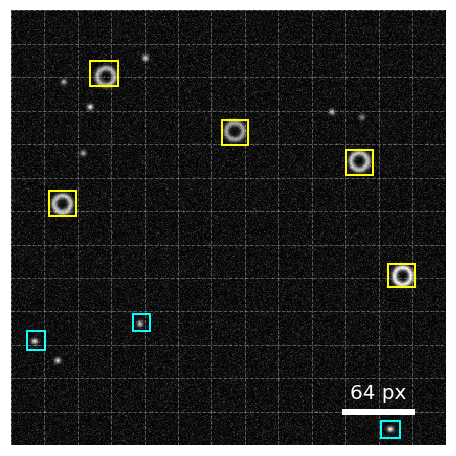

In [9]:
snr = 30
OBJ_THRESHOLD = 0.6
IOU_THRESHOLD = 0.45
color_list = ['cyan', 'yellow']

i = 0
bboxes_truth, _, image = ig.generateImage(objects[i], IMAGE_W, IMAGE_H, snr, a_range=[0.5,1])  # a_range=[0.1,1]
#image = ig.addPerlinNoise(image, 0.5, seed=np.random.randint(0,100))
input_tensor = np.expand_dims(np.stack((image, image, image)/image.max(), axis=-1), 0) # reshape image to input tensor shape
output = session.run(output_tensor, {'import/' + INPUT_NODE_NAME + ':0': input_tensor}) # run model
bboxes_model = decode_netout(output[0], ANCHORS, CLASSES, OBJ_THRESHOLD, IOU_THRESHOLD) # decode output tensor

fig, ax = plt.subplots(1, 1, figsize=(8,8))

image = input_tensor[0,:,:,0]*255
draw_boxes(image, ax, bboxes_model, color_list, lw=2)

#for bbox in bboxes_truth:
#    (xmin, ymin), (xmax, ymax) = bbox[0], bbox[1]
#    ax.add_patch(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='yellow', facecolor='none'))
    
ax.set_xlim(0, IMAGE_W)
ax.set_ylim(IMAGE_H, 0)

ax.set_xticks(np.arange(0, IMAGE_W+1, step=32))
ax.set_yticks(np.arange(0, IMAGE_H+1, step=32))
ax.grid(lw=1, color='w', ls='--', alpha=0.3)  

ax.imshow(image, cmap='gray')

# scale bar
sb_x, sb_y = 352, 384
sb_px = 64
ax.text(sb_x, sb_y/1.05, str(sb_px) + ' px', va='center',ha='center', color='w', fontsize=20)
ax.plot([sb_x-sb_px/2, sb_x+sb_px/2], [sb_y, sb_y], 'w', lw=6);

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)
ax.tick_params(tick1On=False, tick2On=False)

#plt.savefig(path + 'SNR20_Sample.pdf', bbox_inches='tight', pad_inches=0.025)